In [47]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import log_loss
from numpy.linalg import inv
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [48]:
# read in 4th down decision from 2016-2024
# note: most of code in this notebook is similar to behavior_2016_2024_epa.ipynb
path = "data/decisions_2016_2024.csv"
df = pd.read_csv(path)

In [49]:
# check table columns
df.columns

Index(['season', 'week', 'game_id', 'game_date', 'play_id', 'posteam',
       'defteam', 'home_team', 'away_team', 'posteam_type', 'qtr',
       'game_seconds_remaining', 'half_seconds_remaining',
       'quarter_seconds_remaining', 'down', 'ydstogo', 'yardline_100',
       'score_differential', 'home_timeouts_remaining',
       'away_timeouts_remaining', 'posteam_timeouts_remaining',
       'defteam_timeouts_remaining', 'roof', 'surface', 'temp', 'wind',
       'play_type', 'punt_attempt', 'field_goal_attempt', 'rush_attempt',
       'pass_attempt', 'epa', 'wpa', 'success', 'yards_gained', 'first_down',
       'touchdown', 'field_goal_result', 'kick_distance', 'punt_inside_twenty',
       'punt_out_of_bounds', 'punt_downed', 'punt_fair_catch', 'return_yards',
       'penalty', 'aborted_play', 'play_deleted', 'goal_to_go', 'timeout',
       'timeout_team', 'off_epa_4w', 'def_epa_4w', 'plays_in_drive_so_far',
       'play_elapsed_s', 'game_time_elapsed', 'def_time_on_field_cum',
       

In [50]:
actions = ["go", "punt", "fg"]
reward = "wpa" # keep as "epa" for EPA notebook, "wpa" for WPA notebook

In [51]:
df = df[df["action"].isin(actions)].copy()
df

,season,week,game_id,game_date,play_id,posteam,defteam,home_team,away_team,posteam_type,...,play_elapsed_s,game_time_elapsed,def_time_on_field_cum,def_time_on_field_share,is_q4_or_later,action,fg_pct_short,fg_pct_mid,fg_pct_long,punt_net_4w
0,2016,1,2016_01_BUF_BAL,2016-09-11,198.0,BAL,BUF,BAL,BUF,home,...,13.0,188.0,188.0,1.000000,0,punt,0.997562,0.870584,0.704809,31.565077
1,2016,1,2016_01_BUF_BAL,2016-09-11,285.0,BUF,BAL,BAL,BUF,away,...,33.0,318.0,122.0,0.383648,0,punt,0.950380,0.738880,0.652809,30.212951
2,2016,1,2016_01_BUF_BAL,2016-09-11,570.0,BUF,BAL,BAL,BUF,away,...,0.0,570.0,212.0,0.371930,0,punt,0.950380,0.738880,0.652809,30.212951
3,2016,1,2016_01_BUF_BAL,2016-09-11,798.0,BAL,BUF,BAL,BUF,home,...,37.0,859.0,617.0,0.718277,0,fg,0.997562,0.870584,0.704809,31.565077
4,2016,1,2016_01_BUF_BAL,2016-09-11,986.0,BUF,BAL,BAL,BUF,away,...,35.0,1013.0,360.0,0.355380,0,punt,0.950380,0.738880,0.652809,30.212951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31844,2024,18,2024_18_WAS_DAL,2025-01-05,2540.0,DAL,WAS,DAL,WAS,home,...,38.0,2165.0,1364.0,0.630023,0,fg,0.833333,0.851852,0.800000,39.750000
31845,2024,18,2024_18_WAS_DAL,2025-01-05,3299.0,DAL,WAS,DAL,WAS,home,...,4.0,2765.0,1732.0,0.626401,1,fg,0.833333,0.851852,0.800000,39.750000
31846,2024,18,2024_18_WAS_DAL,2025-01-05,4010.0,WAS,DAL,DAL,WAS,away,...,16.0,3259.0,1115.0,0.342129,1,punt,1.000000,0.909091,0.200000,37.625000
31847,2024,18,2024_18_WAS_DAL,2025-01-05,4136.0,DAL,WAS,DAL,WAS,home,...,0.0,3395.0,2117.0,0.623564,1,punt,0.833333,0.851852,0.800000,39.750000


In [52]:
df = df[~df[reward].isna()].copy()

In [53]:
numeric_candidates = [
    # core context
    'yardline_100','ydstogo','score_differential','qtr','game_seconds_remaining',
    # team strength (rolling averages)
    'off_epa_4w','def_epa_4w',
    # special teams
    'fg_pct_short','fg_pct_mid','fg_pct_long','punt_net_4w',
    # fatigue / drive
    'plays_in_drive_so_far','def_time_on_field_cum','def_time_on_field_share',
    # timeouts
    'home_timeouts_remaining','away_timeouts_remaining',
    'posteam_timeouts_remaining','defteam_timeouts_remaining',
    # weather
    'temp','wind',
    # situational
    'goal_to_go'
]


In [54]:
present_numeric = [c for c in numeric_candidates if c in df.columns]

present_numeric

['yardline_100',
 'ydstogo',
 'score_differential',
 'qtr',
 'game_seconds_remaining',
 'off_epa_4w',
 'def_epa_4w',
 'fg_pct_short',
 'fg_pct_mid',
 'fg_pct_long',
 'punt_net_4w',
 'plays_in_drive_so_far',
 'def_time_on_field_cum',
 'def_time_on_field_share',
 'home_timeouts_remaining',
 'away_timeouts_remaining',
 'posteam_timeouts_remaining',
 'defteam_timeouts_remaining',
 'temp',
 'wind',
 'goal_to_go']

In [55]:
cat_options = ['posteam','defteam','home_team','away_team',
    'roof','surface']

In [56]:
cat_candidates = [c for c in cat_options if c in df.columns] # make sure desired columns are in dataframe

cat_candidates


['posteam', 'defteam', 'home_team', 'away_team', 'roof', 'surface']

In [57]:
from sklearn.impute import SimpleImputer

feature_cols = present_numeric + cat_candidates
X_raw = df[feature_cols].replace([np.inf, -np.inf], np.nan) # replace inf with nan
y = df["action"] 
r = df[reward].astype(float).to_numpy() # ensure wpa is float

mask = y.notna()
X_fit, y_fit = X_raw.loc[mask], y.loc[mask] # only use rows with non-missing action for fitting

num_tf = make_pipeline(SimpleImputer(strategy="median"), StandardScaler()) # transformer

# combine numeric and categorical transformers
transformers = [("num", num_tf, present_numeric)]
if cat_candidates:
    cat_tf = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    )
    transformers.append(("cat", cat_tf, cat_candidates))

pre = ColumnTransformer(transformers=transformers)

In [58]:
missing = X_fit.isna().sum()
print("Missing (pre-impute view):")
print(missing[missing > 0])

Missing (pre-impute view):
temp       11046
wind       11046
surface      577
dtype: int64


In [59]:
# build and fit behavior model (logistic regression with preprocessing)
beh_model = make_pipeline(
    pre,
    LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=2000,
        C=1.0
    )
)
beh_model.fit(X_fit, y_fit)

# extract learned classes and predicted probabilities
log_reg = beh_model.named_steps["logisticregression"]
classes = list(log_reg.classes_)
probs = beh_model.predict_proba(X_fit)

# map each action label to its index
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
a_idx = y_fit.map(class_to_idx).to_numpy()

# logged policy probabilities (probability assigned to the taken action)
p_b_logged = probs[np.arange(len(X_fit)), a_idx]

# summary stats
mean_probs = probs.mean(axis=0)
pred_labels = probs.argmax(axis=1)
acc = (pred_labels == a_idx).mean()

print("Classes:", classes)
print("Average action probabilities:",
      dict(zip(classes, np.round(mean_probs, 3))))
print("In-sample accuracy:", round(acc, 3))
print("Logged probs (min / mean / max):",
      np.min(p_b_logged), np.mean(p_b_logged), np.max(p_b_logged))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classes: ['fg', 'go', 'punt']
Average action probabilities: {'fg': 0.263, 'go': 0.178, 'punt': 0.558}
In-sample accuracy: 0.857
Logged probs (min / mean / max): 5.0886632945452674e-06 0.7856094201385495 0.9999997126923676


In [ ]:
#Save Logistic Regression model for further evaluation
import os, joblib
os.makedirs("artifacts", exist_ok=True)
joblib.dump(beh_model, "artifacts/behavior_policy.joblib", compress=3)
print("Saved behavior policy to artifacts/behavior_policy.joblib")

                                   fg        go      punt  importance
num__yardline_100           -2.947980 -0.105345  3.053326    2.035550
num__game_seconds_remaining  0.267159 -1.461261  1.194102    0.974174
num__ydstogo                 0.689755 -1.227180  0.537425    0.818120
num__score_differential      0.201563 -0.649606  0.448044    0.433071
num__def_time_on_field_cum   0.140979 -0.581971  0.440992    0.387981
num__goal_to_go              0.043256  0.529190 -0.572445    0.381630
cat__roof_outdoors          -0.282633 -0.178977  0.461610    0.307740
cat__home_team_BUF          -0.210269 -0.187434  0.397703    0.265136
num__qtr                    -0.037462 -0.347643  0.385105    0.256737
cat__posteam_PHI            -0.115294  0.338281 -0.222987    0.225521


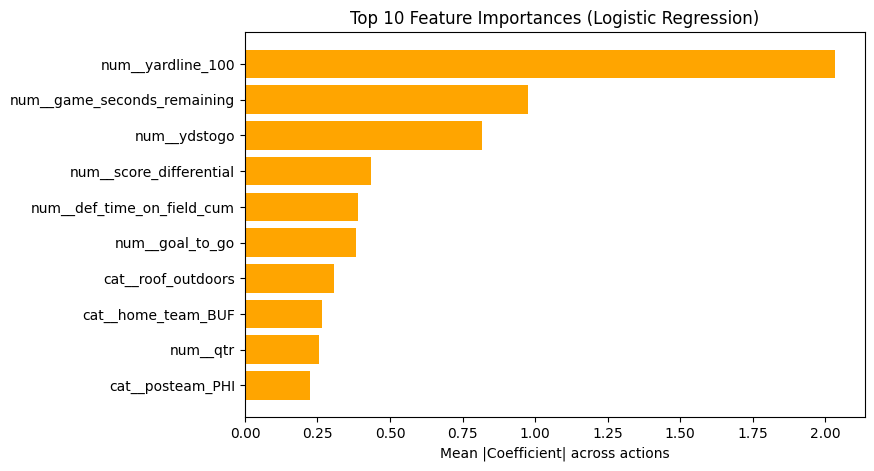

In [60]:
import matplotlib.pyplot as plt

log_reg = beh_model.named_steps["logisticregression"]
feature_names = beh_model.named_steps["columntransformer"].get_feature_names_out()
coefs = log_reg.coef_ # get coeffecients of features to derive feature importance

# Put coefficients into a DataFrame
coef_df = pd.DataFrame(coefs.T, index=feature_names, columns=log_reg.classes_)

# compute importance as mean absolute coefficient across classes
coef_df["importance"] = coef_df.abs().mean(axis=1)

# select top 10
top10 = coef_df.sort_values("importance", ascending=False).head(10)

print(top10)

# plot bar chart
plt.figure(figsize=(8, 5))
plt.barh(top10.index, top10["importance"], color="orange")
plt.xlabel("Mean |Coefficient| across actions")
plt.title("Top 10 Feature Importances (Logistic Regression)")
plt.gca().invert_yaxis()  # highest at top
plt.show()

In [61]:
pre = beh_model.named_steps['columntransformer']
X_design = pre.transform(X_fit)

In [62]:
arm_models = {} # dictionary to hold models for each action
min_n = 50 # minimum samples to fit linear model
l2 = 5.0 # l2 regularization strength
r_fit = df.loc[mask, reward].astype(float).to_numpy() # ensure reward is float

for a in classes:
    arm_mask = (y_fit == a).to_numpy() # fit separate model for each action
    X_arm = X_design[arm_mask] # design matrix for this action
    y_arm = r_fit[arm_mask] # rewards for this action

    if len(y_arm) < min_n: # not enough samples to fit model
        mu = float(np.mean(y_arm)) if y_arm.size else 0.0 # use mean reward or 0 if no samples
        arm_models[a] = ("const", mu) # store as constant model
    else:
        arm_models[a] = Ridge(alpha=l2, fit_intercept=True).fit(X_arm, y_arm) # fit ridge regression model

In [63]:
# function to predict mu for all actions
def predict_mu_all(Xd):
    N, K = Xd.shape[0], len(classes)
    MU = np.zeros((N, K), dtype=float)
    for j, a in enumerate(classes):
        m = arm_models[a]
        if isinstance(m, tuple) and m[0] == "const":
            MU[:, j] = m[1]
        else:
            MU[:, j] = m.predict(Xd)
    return MU

MU = predict_mu_all(X_design)
N_fit = MU.shape[0] # number of fitted samples

In [64]:
from scipy import sparse

# hyperparameters
alpha = 0.8
lambda_ucb = 5.0

X = X_design # design matrix
N, d = X.shape # number of samples, number of features
K = len(classes) # number of actions

# helper functions
def arm_params(model, d): 
    """Return (intercept, theta, is_const) for an arm model."""
    if isinstance(model, tuple) and model[0] == "const":
        return float(model[1]), np.zeros(d), True
    return float(model.intercept_), model.coef_.reshape(-1), False

def quad_form_rows(X, M):
    """Row-wise quadratic form: diag(X M X^T)."""
    if sparse.issparse(X):
        XM = X @ M
        return np.array(X.multiply(XM).sum(axis=1)).ravel()
    XM = X @ M
    return np.sum(X * XM, axis=1)

# precompute group indices once
idx_by_class = {a: np.where((y_fit == a).to_numpy())[0] for a in classes}

# precompute per-arm params and (X^T X + λI)^(-1)
V_inv, theta, intercepts = {}, {}, {}
for a in classes:
    idx = idx_by_class[a]
    Xa = X[idx]

    b0, th, _ = arm_params(arm_models[a], d)
    intercepts[a], theta[a] = b0, th

    if Xa.shape[0] < d + 1:
        V_inv[a] = np.eye(d) / lambda_ucb
    else:
        XtX = Xa.T @ Xa
        V_inv[a] = inv(XtX + lambda_ucb * np.eye(d))

# greedy direct method
a_star_DM_idx = MU.argmax(axis=1)

# LinUCB scores
scores_ucb = np.empty_like(MU)
for j, a in enumerate(classes):
    mu = X @ theta[a] + intercepts[a]
    quad = quad_form_rows(X, V_inv[a])
    bonus = alpha * np.sqrt(np.maximum(quad, 0.0))
    scores_ucb[:, j] = mu + bonus

a_star_UCB_idx = scores_ucb.argmax(axis=1) # index of chosen action by LinUCB

In [65]:
# doubly robust off-policy evaluation (OPE) for DM and UCB
# all arrays are length N_fit
p_b_logged_fit = p_b_logged # behavior policy probabilty assigned to action actually take on each play
a_idx_fit = a_idx # index of logged action

def dr_ope(a_star_idx):
    N = N_fit  
    w_ips_num = (a_idx_fit == a_star_idx).astype(float) # 1 if target action == logged action else 0
    w_ips = w_ips_num / np.clip(p_b_logged_fit, 1e-6, 1.0)

    mu_logged = MU[np.arange(N), a_idx_fit] # \hat\mu(x_i, a_i)
    mu_target = MU[np.arange(N), a_star_idx] # \hat\mu(x_i, a^\*_i)

    dr = np.mean(w_ips * (r_fit - mu_logged) + mu_target) # model-based value under target action + a correction using the logged reward and importance weights.
    ips = np.mean(w_ips * r_fit) # pure importance-weighted average of logged rewards

    w_match = w_ips[w_ips_num == 1.0]
    ess = (w_match.sum()**2 / np.sum(w_match**2)) if w_match.size else 0.0 # measures how many independent samples your weights act like
    return float(dr), float(ips), float(ess)

dr_DM, ips_DM, ess_DM = dr_ope(a_star_DM_idx)
dr_UCB, ips_UCB, ess_UCB = dr_ope(a_star_UCB_idx)

In [66]:
# stochastic: policy does not always pick the same action for a given situation — instead, it assigns probabilities to each action and samples from them.

def dr_ope_stochastic(P_eval):
    """
    Doubly-robust OPE for a *stochastic* target policy.
    P_eval: (N_fit, K) matrix, row i sums to 1, columns align with `classes`.
    Uses p_b_logged_fit, a_idx_fit, r_fit, MU (all length N_fit).
    """
    # logged action prob under eval policy and behavior policy
    pi_e_logged = P_eval[np.arange(N_fit), a_idx_fit]              # (N,)
    w = pi_e_logged / np.clip(p_b_logged_fit, 1e-6, 1.0)           # importance ratio

    mu_logged = MU[np.arange(N_fit), a_idx_fit]                    # (N,)
    mu_target = np.sum(P_eval * MU, axis=1)                        # E_{a~π_e}[μ̂(x,a)]

    dr = np.mean(w * (r_fit - mu_logged) + mu_target)
    ips = np.mean(w * r_fit)
    
    # ESS on rows where pi_e_logged>0
    w_pos = w[pi_e_logged > 0]
    ess = (w_pos.sum()**2) / (np.sum(w_pos**2) + 1e-12) if w_pos.size else 0.0
    return float(dr), float(ips), float(ess)


In [67]:
# bootstrap: resampling with replacement to get CI around DR estimate
rng = np.random.default_rng(123) # for reproducibility
B = 100 # number of bootstrap samples

def bootstrap_dr(a_star_idx):
    vals = []
    for _ in range(B):
        idx = rng.integers(0, N_fit, size=N_fit)
        w_num_b = (a_idx_fit[idx] == a_star_idx[idx]).astype(float)
        w_b = w_num_b / np.clip(p_b_logged_fit[idx], 1e-6, 1.0) 
        mu_logged_b = MU[idx, a_idx_fit[idx]]
        mu_target_b = MU[idx, a_star_idx[idx]]
        dr_b = np.mean(w_b * (r_fit[idx] - mu_logged_b) + mu_target_b)
        vals.append(dr_b)
    return np.percentile(vals, [2.5, 97.5])

ci_DM = bootstrap_dr(a_star_DM_idx)
ci_UCB = bootstrap_dr(a_star_UCB_idx)

In [68]:
summary = pd.DataFrame({
    "policy": ["Greedy-DM (argmax mu)", "LinUCB (pre-game)"],
    "estimate_DR_WPA": [dr_DM, dr_UCB],
    "DR_95%_CI_low": [ci_DM[0], ci_UCB[0]],
    "DR_95%_CI_high": [ci_DM[1], ci_UCB[1]],
    "IPS_only_WPA": [ips_DM, ips_UCB],
    "IPS_ESS": [ess_DM, ess_UCB],
})

diag_df = pd.DataFrame({
    "metric": (["N_rows_used", "behavior_pred_accuracy", "mean_logged_reward"]
               + [f"p_b_mean_{c}" for c in classes]),
    "value": ([N_fit, float(acc), float(np.mean(r_fit))]
              + [float(p) for p in mean_probs]),
})


In [69]:
summary

,policy,estimate_DR_WPA,DR_95%_CI_low,DR_95%_CI_high,IPS_only_WPA,IPS_ESS
0,Greedy-DM (argmax mu),0.021517,0.011070,0.029371,0.015650,314.006127
1,LinUCB (pre-game),0.059666,0.003678,0.156221,0.060933,43.488049


In [70]:
diag_df

,metric,value
0,N_rows_used,31849.000000
1,behavior_pred_accuracy,0.856510
2,mean_logged_reward,0.003046
3,p_b_mean_fg,0.263338
4,p_b_mean_go,0.178343
5,p_b_mean_punt,0.558319


We evaluated two policies on 4th down using **Win Probability Added (WPA)**:

- **Greedy-DM (argmax μ):**  
  - DR estimate: **+0.022 WPA per play**  
  - 95% CI: [0.011, 0.029]  
  - Interpretation: Following the greedy policy would increase win probability by ~2% of a win **for every 100 plays** compared to historical coaching. The confidence interval excludes 0, so this gain is statistically meaningful.  

- **LinUCB (pre-game):**  
  - DR estimate: **+0.060 WPA per play**  
  - 95% CI: [0.004, 0.156]  
  - Interpretation: LinUCB shows a larger upside, with potential to add ~6% of a win **for every 100 plays**. The interval is wider (reflecting higher variance), but it still suggests a positive effect.  

**Diagnostics:**  
- Behavior model accuracy ≈ 86% → reliable logging policy model.  
- Mean logged reward (historical coaching) ≈ 0.003 WPA per play → essentially break-even.  
- Both greedy and LinUCB clearly improve over the baseline.  
- Effective Sample Size (ESS):  
  - Greedy ≈ 314 (very stable estimates).  
  - LinUCB ≈ 44 (much smaller ESS, so results are noisier).  

**Bottom line:**  
Analytics-driven 4th-down policies (Greedy, LinUCB) increase win probability compared to historical decisions, with LinUCB showing higher potential upside but also more variance.

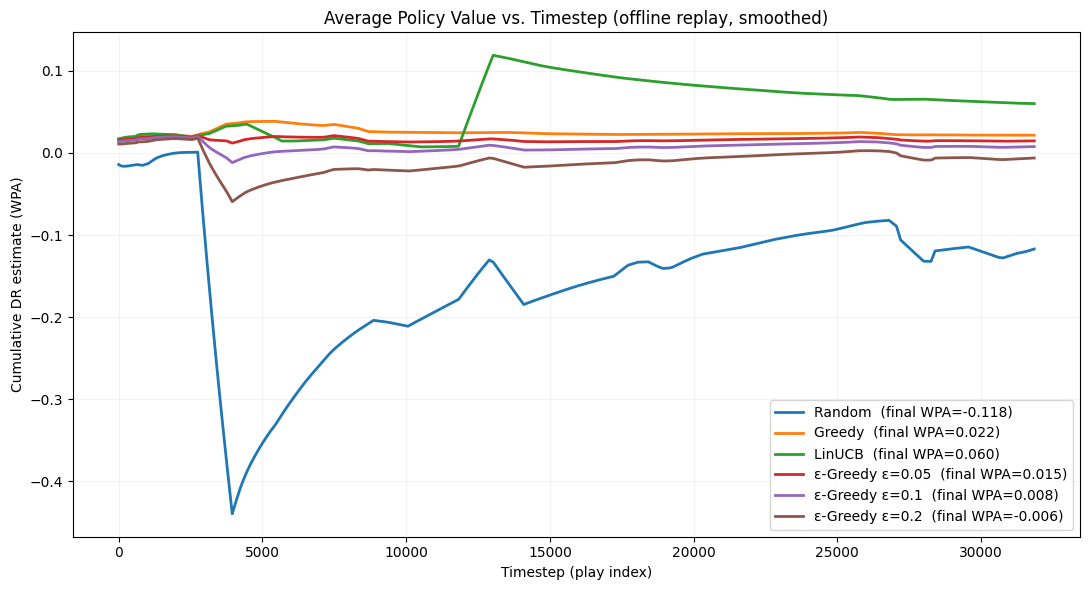

In [71]:
import matplotlib.pyplot as plt

def dr_per_row_det(a_star_idx, MU, r, a_log, p_b):
    N = len(r)
    w_num = (a_log == a_star_idx).astype(float)
    w = w_num / np.clip(p_b, 1e-6, 1.0)
    mu_log = MU[np.arange(N), a_log]
    mu_tgt = MU[np.arange(N), a_star_idx]
    return w * (r - mu_log) + mu_tgt

def dr_per_row_sto(Pi_e, MU, r, a_log, p_b):
    N = len(r)
    pi_e_logged = Pi_e[np.arange(N), a_log]
    w = pi_e_logged / np.clip(p_b, 1e-6, 1.0)
    mu_log = MU[np.arange(N), a_log]
    mu_tgt = np.sum(Pi_e * MU, axis=1)
    return w * (r - mu_log) + mu_tgt

def pi_random(N, K):
    return np.full((N, K), 1.0 / K, dtype=float)

def pi_epsgreedy(MU, epsilon=0.1):
    N, K = MU.shape
    Pi = np.full((N, K), epsilon / K, dtype=float)
    g = MU.argmax(axis=1)
    Pi[np.arange(N), g] += (1.0 - epsilon)
    return Pi

def cummean(x):
    return np.cumsum(x) / np.arange(1, len(x) + 1)

def smooth(y, win=501):
    """Centered rolling mean; falls back if series shorter than window."""
    win = min(win, max(3, (len(y)//20)*2+1))  # odd window; ~5% of series if long
    return pd.Series(y).rolling(win, center=True, min_periods=1).mean().to_numpy()

def plot_policy_learning_curves(
    MU, r_fit, a_idx_fit, p_b_logged_fit, a_star_DM_idx, a_star_UCB_idx,
    ylabel="WPA", shuffle=True, seed=0, smooth_win=501, show_random=True
):
    rng = np.random.default_rng(seed)
    N, K = MU.shape
    order = rng.permutation(N) if shuffle else np.arange(N)

    psi_greedy = dr_per_row_det(a_star_DM_idx, MU, r_fit, a_idx_fit, p_b_logged_fit)[order]
    psi_ucb    = dr_per_row_det(a_star_UCB_idx, MU, r_fit, a_idx_fit, p_b_logged_fit)[order]

    curves = {}
    if show_random:
        psi_rand = dr_per_row_sto(pi_random(N, K), MU, r_fit, a_idx_fit, p_b_logged_fit)[order]
        curves["Random"] = cummean(psi_rand)

    curves["Greedy"] = cummean(psi_greedy)
    curves["LinUCB"] = cummean(psi_ucb)

    for eps in [0.05, 0.10, 0.20]:
        Pi = pi_epsgreedy(MU, epsilon=eps)
        psi_eps = dr_per_row_sto(Pi, MU, r_fit, a_idx_fit, p_b_logged_fit)[order]
        curves[f"ε-Greedy ε={eps:g}"] = cummean(psi_eps)

    # Smooth & collect terminal values
    curves_s = {k: smooth(v, win=smooth_win) for k, v in curves.items()}
    finals = {k: float(v[-1]) for k, v in curves.items()}

    plt.figure(figsize=(11,6))
    for name, y in curves_s.items():
        lab = f"{name}  (final {ylabel}={finals[name]:.3f})"
        plt.plot(y, label=lab, linewidth=2)

    plt.xlabel("Timestep (play index)")
    plt.ylabel(f"Cumulative DR estimate ({ylabel})")
    plt.title(f"Average Policy Value vs. Timestep (offline replay, smoothed)")
    plt.legend(loc="best", fontsize=10)
    plt.grid(alpha=0.15)
    plt.tight_layout()
    plt.show()

    return finals


finals_wpa = plot_policy_learning_curves(MU, r_fit, a_idx_fit, p_b_logged_fit,
                                         a_star_DM_idx, a_star_UCB_idx,
                                         ylabel="WPA", shuffle=True, seed=7, smooth_win=1201)



The uptick in the LinUCB curve comes from its exploration bonus — it briefly overestimates the value of less certain actions, which boosts its estimated WPA before settling. Importantly, it still converges above the other policies, suggesting a higher long-run win probability compared to Greedy or ε-greedy.

In [72]:
P_b = beh_model.predict_proba(X_fit)

dr_eq, ips_eq, ess_eq = dr_ope_stochastic(P_b)   # P_b from your fitted behavior model
print("DR(π_e = π_b) =", dr_eq, "  mean_logged_reward =", r_fit.mean())
# make sure these two numbers are very close because the doubly robust estimate should equal the mean logged reward when the evaluation policy equals the behavior policy

DR(π_e = π_b) = 0.003049089472202051   mean_logged_reward = 0.0030457610692848657


In [73]:
wpa_by_action = (
    df.groupby("action")["wpa"]
      .agg(["count", "mean", "std", "min", "max"])
      .reset_index()
)

print(wpa_by_action)

# sort by mean wpa to see which action looks best on average
wpa_by_action.sort_values("mean", ascending=False)

  action  count      mean       std       min       max
0     fg   8388  0.000841  0.062224 -0.683856  0.570333
1     go   5678  0.007348  0.088628 -0.752197  0.862577
2   punt  17783  0.002712  0.045451 -0.418035  0.944656


,action,count,mean,std,min,max
1,go,5678,0.007348,0.088628,-0.752197,0.862577
2,punt,17783,0.002712,0.045451,-0.418035,0.944656
0,fg,8388,0.000841,0.062224,-0.683856,0.570333


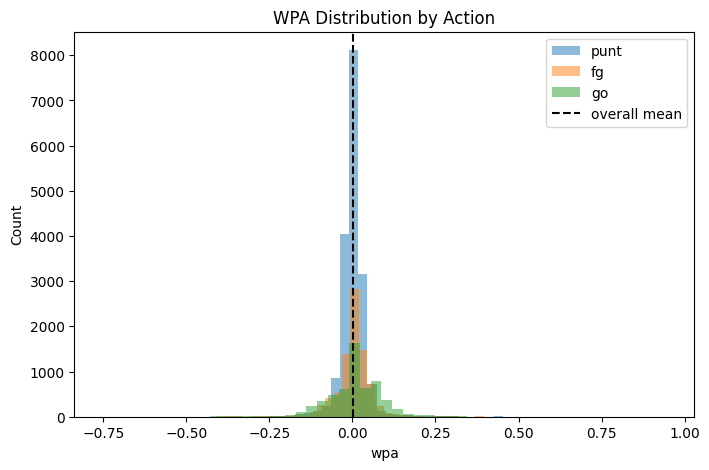

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for a in df["action"].unique():
    subset = df.loc[df["action"] == a, "wpa"]
    plt.hist(subset, bins=50, alpha=0.5, label=a)
plt.axvline(df["wpa"].mean(), color="k", linestyle="--", label="overall mean")
plt.xlabel("wpa")
plt.ylabel("Count")
plt.title("WPA Distribution by Action")
plt.legend()
plt.show()


In [75]:
# bin yardline into field zones (e.g. red zone, midfield, own territory)
df['yardline_bin'] = pd.cut(
    df['yardline_100'],
    bins=[0, 20, 40, 60, 80, 100],
    labels=["Red Zone (0-20)", "Opp 20-40", "Midfield (40-60)", "Own 40-20", "Own 20+"]
)

wpa_by_yardline = (
    df.groupby(['yardline_bin', 'action'])['wpa']
      .agg(['count', 'mean'])
      .reset_index()
      .sort_values(['yardline_bin','action'])
)

print(wpa_by_yardline)


        yardline_bin action  count      mean
0    Red Zone (0-20)     fg   4241 -0.003972
1    Red Zone (0-20)     go   1417 -0.003196
2    Red Zone (0-20)   punt      0       NaN
3          Opp 20-40     fg   4098  0.005833
4          Opp 20-40     go   1759  0.008645
5          Opp 20-40   punt    538 -0.015667
6   Midfield (40-60)     fg     49 -0.000011
7   Midfield (40-60)     go   1600  0.016161
8   Midfield (40-60)   punt   6035  0.001484
9          Own 40-20     fg      0       NaN
10         Own 40-20     go    789  0.006045
11         Own 40-20   punt   8644  0.004754
12           Own 20+     fg      0       NaN
13           Own 20+     go    113  0.003696
14           Own 20+   punt   2566  0.002573


In [76]:
df['ydstogo_bin'] = pd.cut(
    df['ydstogo'],
    bins=[0, 2, 5, 10, 20, 100],
    labels=["1-2", "3-5", "6-10", "11-20", "20+"]
)

wpa_by_ydstogo = (
    df.groupby(['ydstogo_bin','action'])['wpa']
      .agg(['count','mean'])
      .reset_index()
      .sort_values(['ydstogo_bin','action'])
)

print(wpa_by_ydstogo)


   ydstogo_bin action  count      mean
0          1-2     fg    961 -0.013769
1          1-2     go   3038  0.013026
2          1-2   punt   2113 -0.008619
3          3-5     fg   2376 -0.003471
4          3-5     go   1253  0.006922
5          3-5   punt   3676 -0.000953
6         6-10     fg   3270  0.002003
7         6-10     go    920 -0.004480
8         6-10   punt   6299  0.002645
9        11-20     fg   1634  0.012868
10       11-20     go    402 -0.002555
11       11-20   punt   4872  0.009547
12         20+     fg    147  0.006524
13         20+     go     65 -0.021147
14         20+   punt    823  0.008227


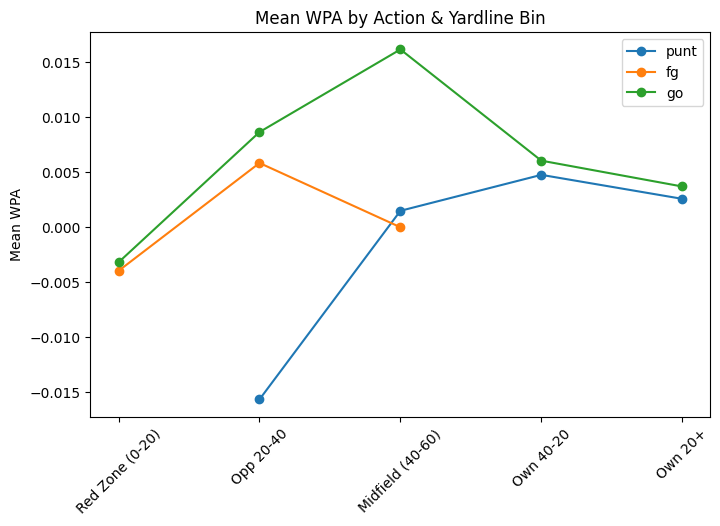

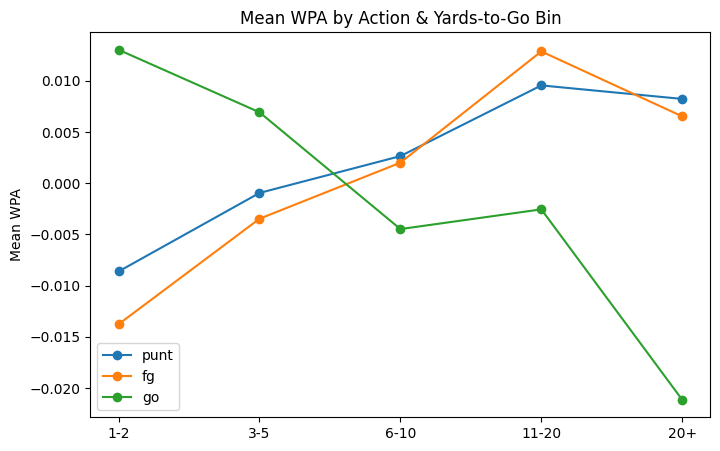

In [77]:
# yardline plot
plt.figure(figsize=(8,5))
for a in df['action'].unique():
    subset = df.groupby('yardline_bin')['epa'].mean().reset_index()
    plt.plot(
        wpa_by_yardline.loc[wpa_by_yardline['action']==a,'yardline_bin'],
        wpa_by_yardline.loc[wpa_by_yardline['action']==a,'mean'],
        marker='o', label=a
    )
plt.xticks(rotation=45)
plt.ylabel("Mean WPA")
plt.title("Mean WPA by Action & Yardline Bin")
plt.legend()
plt.show()

# yards-to-go plot
plt.figure(figsize=(8,5))
for a in df['action'].unique():
    plt.plot(
        wpa_by_ydstogo.loc[wpa_by_ydstogo['action']==a,'ydstogo_bin'],
        wpa_by_ydstogo.loc[wpa_by_ydstogo['action']==a,'mean'],
        marker='o', label=a
    )
plt.ylabel("Mean WPA")
plt.title("Mean WPA by Action & Yards-to-Go Bin")
plt.legend()
plt.show()


In [78]:
# group mean WPA by yardline bin & action
wpa_by_yardline = (
    df.groupby(['yardline_bin','action'])['wpa']
      .mean().unstack()
)

# compute ΔWPA of go vs best alternative
wpa_by_yardline['best_alt'] = wpa_by_yardline[['fg','punt']].max(axis=1)
wpa_by_yardline['delta_go'] = wpa_by_yardline['go'] - wpa_by_yardline['best_alt']

print("Decision table by yardline:")
print(wpa_by_yardline[['fg','punt','go','best_alt','delta_go']])


Decision table by yardline:
action                  fg      punt        go  best_alt  delta_go
yardline_bin                                                      
Red Zone (0-20)  -0.003972       NaN -0.003196 -0.003972  0.000776
Opp 20-40         0.005833 -0.015667  0.008645  0.005833  0.002813
Midfield (40-60) -0.000011  0.001484  0.016161  0.001484  0.014676
Own 40-20              NaN  0.004754  0.006045  0.004754  0.001291
Own 20+                NaN  0.002573  0.003696  0.002573  0.001123


In [79]:
wpa_by_ydstogo = (
    df.groupby(['ydstogo_bin','action'])['epa']
      .mean().unstack()
)

wpa_by_ydstogo['best_alt'] = wpa_by_ydstogo[['fg','punt']].max(axis=1)
wpa_by_ydstogo['delta_go'] = wpa_by_ydstogo['go'] - wpa_by_ydstogo['best_alt']

print("Decision table by ydstogo:")
print(wpa_by_ydstogo[['fg','punt','go','best_alt','delta_go']])


Decision table by ydstogo:
action             fg      punt        go  best_alt  delta_go
ydstogo_bin                                                  
1-2          0.049541 -0.386676  0.317186  0.049541  0.267645
3-5          0.025491 -0.214947  0.146421  0.025491  0.120930
6-10         0.077067 -0.113161 -0.402676  0.077067 -0.479743
11-20        0.046264  0.003906 -0.946915  0.046264 -0.993179
20+          0.081813 -0.073982 -1.410538  0.081813 -1.492351


In [80]:
import os, json, joblib

os.makedirs("artifacts", exist_ok=True)

# load metadata (already saved by EPA notebook)
with open("artifacts/metadata.json", "r") as f:
    meta = json.load(f)
ACTIONS = meta["actions"]

# sanity check (make sure behavior model in WPA nb has the same class order)
assert set(ACTIONS) == {"go", "punt", "fg"}

# save WPA per-arm models
arm_models_wpa = arm_models
joblib.dump(arm_models_wpa, "artifacts/arm_models_wpa.joblib", compress=3)

print("WPA artifacts saved:", os.listdir("artifacts"))


WPA artifacts saved: ['arm_models_wpa.joblib', 'test_infer.py', 'preprocessor.joblib', 'arm_models_epa.joblib', 'metadata.json', '__pycache__', 'inference.py']
